<img style="float: left;" src="figures/model1.png" width="20%">   


# <font color='Blue'> Simple CCS model </font>

## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation of CO$_2$ injection to 1D aquifer with dissolution and precipitation.

## <font color='blue'>The objectives:</font>
Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [CompositionalPhysics](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/physics.py) for compositional physics
 * Class [PropertyContainer](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/property_container.py) for allocating property evaluators needed in simulation
 * Class [CompositionalOperators](https://gitlab.com/open-darts/open-darts/-/blob/development/darts/physics/super/operator_evaluator.py) for defining OBL operators in simulation

## <font color='blue'>Let's start !</font>
### We need to import <font color='red'>engines</font> and nessesary physical properties into the workspace, just like the import of commonly-used modules such as numpy etc.

In [1]:
'''Import all important packages from DARTS installation'''
from darts.reservoirs.struct_reservoir import StructReservoir
from darts.models.darts_model import DartsModel
from darts.engines import sim_params, value_vector, redirect_darts_output
from darts.engines import well_control_iface

from darts.physics.super.physics import Compositional
from darts.physics.super.property_container import PropertyContainer
from darts.physics.base.operators_base import PropertyOperators

from darts.physics.properties.basic import ConstFunc, PhaseRelPerm
from darts.physics.properties.flash import ConstantK
from darts.physics.properties.density import DensityBasic
from darts.physics.properties.kinetics import KineticBasic

import matplotlib.pyplot as plt
import numpy as np

redirect_darts_output('model1.log')

## <font color='Blue'>Brief Introduction of model inheritance:</font>

* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [4]:

class PermPoroRelationship:
    def evaluate(self, poro):
        return poro ** 3
class Model(DartsModel):
    def __init__(self):
        # Call base class constructor
        super().__init__()

        # Measure time spend on reading/initialization
        self.timer.node["initialization"].start()
        solid_init=0.7
        self.set_reservoir(solid_init)
        self.set_physics(solid_init)
        self.set_sim_params(first_ts=0.001, mult_ts=2, max_ts=10, runtime=50, tol_newton=1e-3, tol_linear=1e-5,
                            it_newton=10, it_linear=50, newton_type=sim_params.newton_local_chop)

        self.timer.node["initialization"].stop()

    def set_reservoir(self, solid_init):
        """Reservoir"""
        self.permporo = PermPoroRelationship()
        self.params.enable_permporo = True
        # perm = 100 / phi ** trans_exp
        perm = 100 / self.permporo.evaluate(1 - solid_init)
        self.reservoir = StructReservoir(self.timer, nx=100, ny=1, nz=1, dx=10, dy=1, dz=1,
                                         permx=perm, permy=perm, permz=perm / 10, poro=1, depth=1000)        

    def set_wells(self):
        """well location"""
        self.reservoir.add_well("INJ")
        self.reservoir.add_perforation("INJ", res_cell_idx=(1, 1, 1))

        self.reservoir.add_well("PRD")
        self.reservoir.add_perforation("PRD", res_cell_idx=(self.reservoir.nx, 1, 1))

    def set_physics(self, solid_init: float):
        """ PHYSICS """
        self.zero = 1e-12
        init_ions = 0.5
        equi_prod = (init_ions / 2) ** 2
        self.init_pres = 95

        """Reservoir"""
        self.inj_gas_rate = 0.2
        zc_fl_init = [self.zero / (1 - solid_init), init_ions]
        zc_fl_init = zc_fl_init + [1 - sum(zc_fl_init)]
        self.ini_comp = [x * (1 - solid_init) for x in zc_fl_init]

        """Physical properties"""
        phases = ['gas', 'wat', 'sol']
        components = ['CO2', 'Ions', 'H2O', 'CaCO3']
        Mw = [44.01, (40.078 + 60.008) / 2, 18.015, 100.086]
        nc = len(components)

        zc_fl_inj_stream_gas = [1 - 2 * self.zero, self.zero]
        self.inj_stream_gas = zc_fl_inj_stream_gas + [1 - sum(zc_fl_inj_stream_gas)]


        """ properties correlations """
        pc = PropertyContainer(phases_name=phases, components_name=components, Mw=Mw,
                                             nc_sol=1, np_sol=1, min_z=self.zero / 10, rock_comp=1e-7)

        pc.flash_ev = ConstantK(nc-1, [10, 1e-12, 1e-1], self.zero)

        pc.density_ev = dict([('gas', DensityBasic(compr=1e-4, dens0=100)),
                           ('wat', DensityBasic(compr=1e-6, dens0=1000)),
                           ('sol', ConstFunc(2000.))])
        pc.viscosity_ev = dict([('gas', ConstFunc(0.1)),
                             ('wat', ConstFunc(1))])
        pc.rel_perm_ev = dict([('gas', PhaseRelPerm("gas")),
                            ('wat', PhaseRelPerm("wat"))])
        diff_coef = 1e-9 * 60 * 60 * 24  # convert from m2/s to m2/day
        pc.diffusion_ev = dict([('gas', ConstFunc(np.ones(nc) * diff_coef)),
                                ('wat', ConstFunc(np.ones(nc) * diff_coef))])

        pc.kinetic_rate_ev = {}
        # specify knetic rate [kmol/day]
        pc.kinetic_rate_ev[0] = KineticBasic(equi_prod=equi_prod, kin_rate_cte=1e-0, ne=nc)
        pc.permporo_mult_ev = self.permporo
        """ Activate physics """
        self.physics = Compositional(components, phases, self.timer,
                                     n_points=401, min_p=1, max_p=1000, min_z=self.zero/10, max_z=1-self.zero/10, cache=0)

        self.physics.add_property_region(pc, 0)

    # Initialize reservoir and set boundary conditions:
    def set_initial_conditions(self):
        """ initialize conditions for all scenarios"""
        input_distribution = {comp: self.ini_comp[i] for i, comp in enumerate(self.physics.components[:-1])}
        input_distribution.update({'pressure': self.init_pres})
        self.physics.set_initial_conditions_from_array(mesh=self.reservoir.mesh, input_distribution=input_distribution)

    def set_well_controls(self):
        for i, w in enumerate(self.reservoir.wells):
            if "INJ" in w.name:
                self.physics.set_well_controls(wctrl= w.control,
                                               control_type = well_control_iface.MOLAR_RATE,
                                               is_inj = True,
                                               target = self.inj_gas_rate,
                                               phase_name = 'gas',
                                               inj_composition = self.inj_stream_gas)
            else:
                self.physics.set_well_controls(wctrl = w.control, control_type = well_control_iface.BHP,
                                               is_inj = False,
                                               target = 95)

    def print_and_plot_1D(self):
        nc = self.physics.nc
        nb = self.reservoir.mesh.n_res_blocks
        Sg = np.zeros(nb)

        Xn = np.array(self.physics.engine.X, copy=True)

        P = Xn[0:nb * nc:nc]
        phi = (Xn[1:nb * nc:nc] + Xn[2:nb * nc:nc] + Xn[3:nb * nc:nc])
        z_co2 = Xn[1:nb * nc:nc] / phi

        pc = self.physics.property_operators[0].property
        for ii in range(nb):
            x_list = Xn[ii * nc:(ii + 1) * nc]
            state = value_vector(x_list)
            pc.evaluate(state)
            Sg[ii] = pc.sat[0]

        """ start plots """
        fig, ax = plt.subplots(2, 2, figsize=(8, 5), dpi=200, facecolor='w', edgecolor='k')
        names = ['z_co2', 'Sg', 'P', 'phi']
        titles = ['$z_{CO_2}$ [-]', '$s_g$ [-]', '$P$ [bars]', '$\phi$ [-]']
        for i in range(2):
            for j in range(2):
                n = i + j * 2
                vec = eval(names[n])
                im = ax[i, j].plot(vec)
                ax[i, j].set_title(titles[n])

        plt.tight_layout()
        plt.show()

In [5]:
m = Model()
m.init()
m.set_output(output_folder='output/simple_ccs_model')
m.run(3000)

darts-package built on 30/01/2026 16:43:15 by smoslehi@HW1T6M3 from v1.1.3-1733-g0dbd8e12-dirty
Building connection list...
Simulation parameters:
	 eta = [1.e+20 1.e+20 1.e+20 1.e+20]
	 dt_first = 0.001
	 dt_min = 1e-15
	 dt_mult = 2
	 dt_max = 10
	 newton_tol = 0.001
	 newton_tol_wel_mult = 100.0
	 newton_tol_stationary = 0.001
	 newton_max_iter = 10
	 linear_tol = 1e-05
	 linear_max_iter = 50
	 linear_type = None
	 linear_print_level = None
	 line_search = False
	 min_line_search_update = 0.0001
	 coupled_well_res_norm_method = 1
#1	T=0.001	DT=0.001	NI=2	LI=2	DT_MULT=  2	dX=[0.424 0.    0.    0.   ]
#2	T=0.003	DT=0.002	NI=1	LI=1	DT_MULT=  2	dX=[0.393 0.    0.    0.   ]
#3	T=0.007	DT=0.004	NI=1	LI=1	DT_MULT=  2	dX=[0.481 0.    0.    0.   ]
#4	T=0.015	DT=0.008	NI=1	LI=1	DT_MULT=  2	dX=[0.641 0.    0.    0.   ]
#5	T=0.031	DT=0.016	NI=1	LI=1	DT_MULT=  2	dX=[0.884 0.    0.    0.   ]
#6	T=0.063	DT=0.032	NI=1	LI=1	DT_MULT=  2	dX=[1.231 0.    0.    0.   ]
#7	T=0.127	DT=0.064	NI=1	LI=1	DT_MU

0

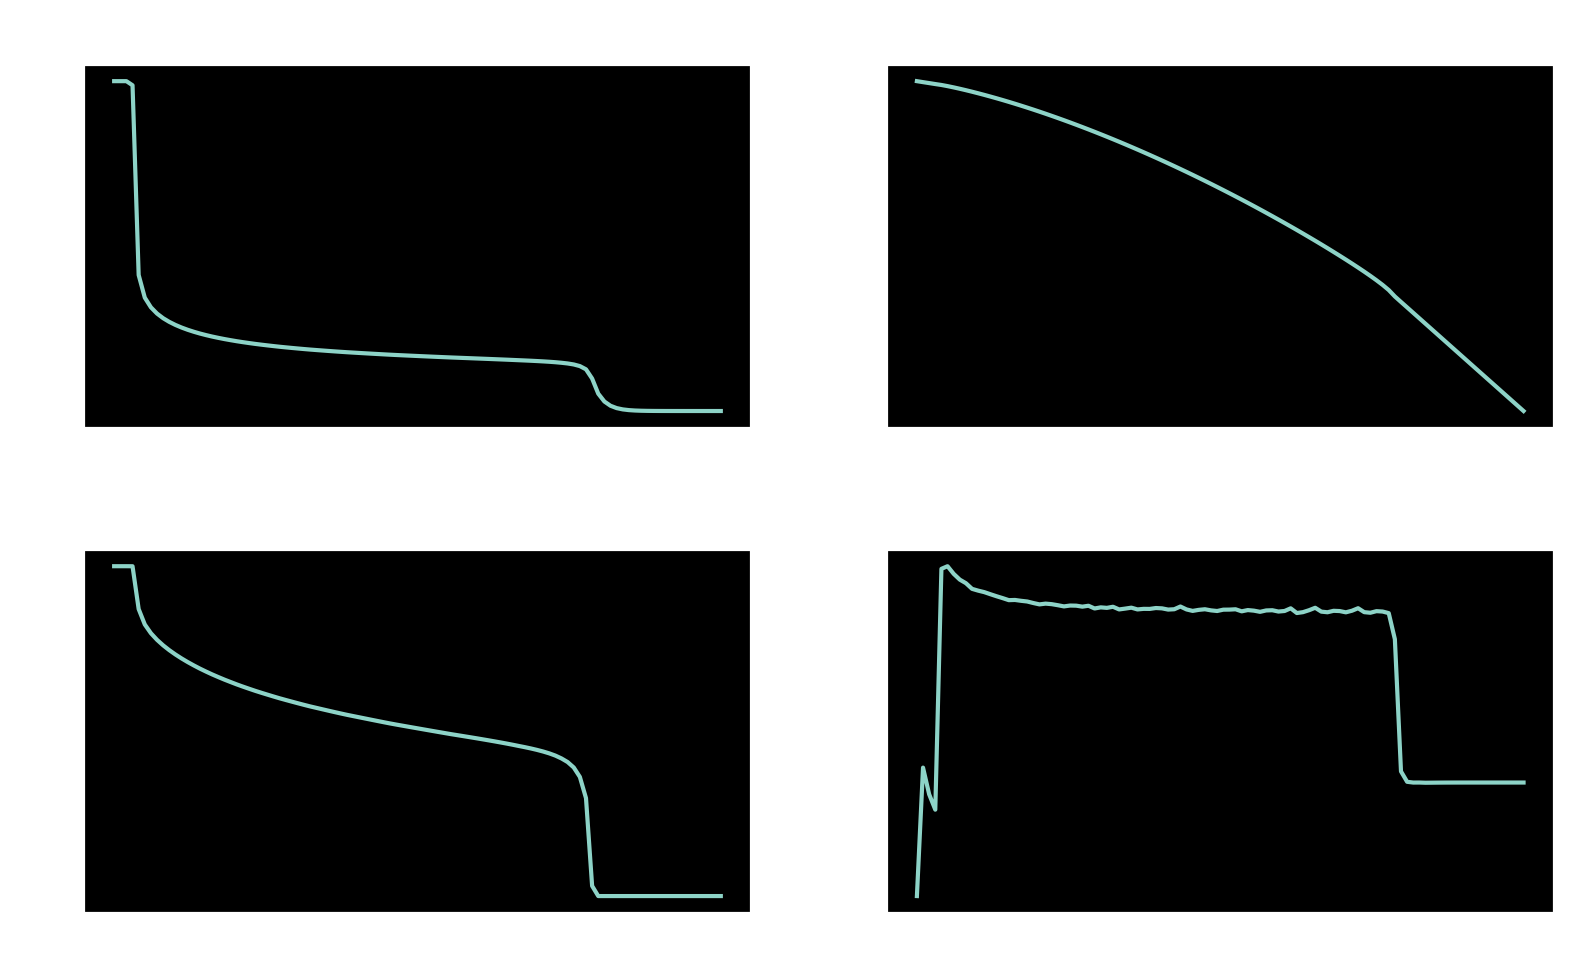

In [6]:
m.print_and_plot_1D()

## <font color='Blue'>Tasks in this workshop (check and explain why the solution behaves this way):</font>

1. Increase spatial resolution by 10 times: increase the number of gridblocks and reduce dx.
2. Reduce the maximum timestep to 1 day to limit oscilliations.
3. Reduce the kinetic rate of reaction by 10 times.

More details on the bechnmark can be found in https://doi.org/10.1007/s10596-024-10268-z and https://doi.org/10.1007/s10596-024-10269-y.